In [ ]:
import os
import gc
import torch
import numpy as np
import random
import time
import psutil
import logging
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import accuracy_score

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
from torch.optim import Adam

from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import glue_processors as processors
from transformers import glue_output_modes as output_modes
from transformers import glue_convert_examples_to_features as convert_examples_to_features

In [5]:
class TrainingArgs:
    def __init__(self):
        self.bert_model = 'bert-base-uncased'
        self.local_rank = -1
        self.data_dir = "glue_data"
        self.overwrite_cache = True
        self.num_labels = 2
        self.batch_size = 8
        self.update_lr = 5e-6
        self.epochs = 3
        self.output_dir = "lr_v6"
        self.train_sample_per_task = 500
        self.eval_sample_per_task = 100
        self.seed = 140
        self.memory_size = 2000
        self.latent_replay_layer = None  # Initialize as None

args = TrainingArgs()

In [6]:
logger=logging.getLogger()

In [7]:
class BertTask_Baseline(Dataset):
    ''' 
    Custom dataset class that loads and preprocesses GLUE datasets.
    It takes a specific task and converts the raw text into tokenized features ready for training or evaluation.
    load_and_cache_examples method handles the loading and caching of the dataset examples.
    '''
    def __init__(self, args, tokenizer, max_seq_length, task, evaluate=False,sample=False):
        """
        :param num_task: number of training tasks.
        :param tokenizer: tokenizer uses to tokenzie from word to sequence
        :param max_seq_length: length of the tokenzier vector
        :param evaluate: indicate whether the dataset is from training/ evaluate sets
        """
        self.tokenizer       = tokenizer
        self.max_seq_length  = max_seq_length
        self.evaluate        = evaluate
        self.local_rank      = args.local_rank
        self.data_dir        = args.data_dir
        self.bert_model      = args.bert_model
        self.overwrite_cache = args.overwrite_cache
        self.sample = sample
        self.task = task
        self.create_batch()
        
    def create_batch(self):
        '''
        Randomly select number of examples from each task into supports (meta training dataset) and queries (meta evaluating dataset)
        '''
        # 1. randomly select num_task GLUE tasks 
        task = self.task 
        self.dataset = self.load_and_cache_examples(task, self.tokenizer, self.evaluate, self.sample) # map style dataset 


    def load_and_cache_examples(self, task, tokenizer, evaluate=False, sample=False):
        '''
        Copied from official loading and cache scripts from Huggingface Transformer load_and_cache_examples
        https://github.com/huggingface/transformers/blob/master/examples/run_glue.py#L334
        '''
        folder_name = {'cola': 'CoLA', 'mnli-mm':'MNLI'}
        if task in folder_name:
            task_data_path = folder_name[task]
        else:
            task_data_path = task.upper()


        if self.local_rank not in [-1, 0] and not evaluate:
            torch.distributed.barrier()  
            
        processor = processors[task]()
        output_mode = output_modes[task]
        cached_downloaded_file = os.path.join(self.data_dir, task_data_path)
        # print(cached_downloaded_file)

        logger.info(f"Creating features from dataset file at {cached_downloaded_file}")
        label_list = processor.get_labels()

    
        examples = (
                processor.get_dev_examples(cached_downloaded_file) if evaluate else processor.get_train_examples(cached_downloaded_file)
            )
        
        if sample:
            if args.seed:
                random.seed(args.seed)
            examples = random.sample(examples, sample)

        features = convert_examples_to_features(
            examples, tokenizer, max_length=self.max_seq_length, label_list=label_list, output_mode=output_mode,
        )

        if self.local_rank == 0 and not evaluate:
            torch.distributed.barrier()  
            
        # Convert to Tensors and build dataset
        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
        if output_mode == "classification":
            all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
        elif output_mode == "regression":
            all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset

    def __getitem__(self, index):
        dataset_set = self.dataset[index]
        return dataset_set

    def __len__(self):
        return len(self.dataset)

In [8]:
class Bert_trainer_lr(nn.Module):
    def __init__(self, args):
        """
        :param args:
        """
        super(Bert_trainer_lr, self).__init__()
        self.num_labels = args.num_labels
        self.batch_size = args.batch_size
        self.update_lr = args.update_lr
        self.bert_model = args.bert_model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = BertForSequenceClassification.from_pretrained(self.bert_model, num_labels=self.num_labels)
        self.outer_optimizer = Adam(self.model.parameters(), lr=self.update_lr)
        self.model.train()

        # Latent replay implementation
        self.replay_memory = []  # Initialize replay memory
        self.memory_size = args.memory_size  # Maximum size of the replay memory
        self.latent_replay_layer = args.latent_replay_layer  # Layer to store latent activations

        # Define the criterion for computing the loss
        self.criterion = nn.CrossEntropyLoss()

    def save_latent_representations(self, latent_activations, labels):
        # Save a subset of the latent activations and corresponding labels to the replay memory
        indices = np.random.choice(latent_activations.size(0), size=min(latent_activations.size(0), self.memory_size - len(self.replay_memory)), replace=False)
        self.replay_memory.extend(zip(latent_activations[indices].detach().cpu(), labels[indices].detach().cpu()))

        # If the replay memory exceeds the maximum size, remove the oldest entries
        if len(self.replay_memory) > self.memory_size:
            self.replay_memory = self.replay_memory[-self.memory_size:]

    def replay_latent_representations(self, batch_size):
        # Retrieve a batch of latent activations and labels from the replay memory
        indices = np.random.choice(len(self.replay_memory), size=min(batch_size, len(self.replay_memory)), replace=False)
        latent_activations, labels = zip(*[self.replay_memory[i] for i in indices])
        latent_activations = torch.stack(latent_activations)
        labels = torch.stack(labels)
        return latent_activations, labels

    def forward(self, datasets, training=True):
        num_task = len(datasets)
        self.model.to(self.device)
        acc = None

        if training:
            dataloader = DataLoader(datasets, batch_size=self.batch_size)
            for data in dataloader:
                all_loss = []
                batch = tuple(t.to(self.device) for t in data)
                input_ids, attention_mask, segment_ids, label_id = batch

                # Forward pass
                outputs = self.model(input_ids, attention_mask, segment_ids, output_hidden_states=True)
                latent_activations = outputs.hidden_states[self.latent_replay_layer]

                # Save latent activations to replay memory
                self.save_latent_representations(latent_activations.detach().cpu(), label_id.detach().cpu())

                # Retrieve latent activations from replay memory
                replay_latent_activations, replay_labels = self.replay_latent_representations(batch_size=self.batch_size // 2)

                # Concatenate current and replayed latent activations
                concat_latent_activations = torch.cat((latent_activations, replay_latent_activations.to(self.device)), dim=0)
                concat_labels = torch.cat((label_id, replay_labels.to(self.device)), dim=0)

                # Pass the concatenated latent activations through the remaining layers
                outputs = self.model(inputs_embeds=concat_latent_activations, labels=concat_labels)
                loss = outputs.loss

                loss.backward()

                # Freeze the weights of the layers below the replay layer
                for name, param in self.model.named_parameters():
                    if name.startswith('bert.encoder.layer.0') or name.startswith('bert.encoder.layer.1'):
                        param.requires_grad = False

                self.outer_optimizer.step()
                self.outer_optimizer.zero_grad()

                all_loss.append(loss.item())

            self.model.to(torch.device('cpu'))
            return outputs

        else:
            with torch.no_grad():
                correct = 0
                total = 0
                self.model.to(torch.device(self.device))
                dataloader = DataLoader(datasets, batch_size=self.batch_size)
                for data in dataloader:
                    query_batch = next(iter(dataloader))
                    query_batch = tuple(t.to(self.device) for t in query_batch)
                    q_input_ids, q_attention_mask, q_segment_ids, q_label_id = query_batch

                    q_outputs = self.model(q_input_ids, q_attention_mask, q_segment_ids, labels=q_label_id)
                    q_logits = F.softmax(q_outputs[1], dim=1)
                    pre_label_id = torch.argmax(q_logits, dim=1)

                    total += q_label_id.size(0)
                    correct += pre_label_id.eq(q_label_id.to(self.device).view_as(pre_label_id)).sum().item()

                acc = correct / total
                self.model.to(torch.device('cpu'))
                return acc

def calculate_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss  # Returns the resident set size (RSS) in bytes

def calculate_compute_time(start_time, end_time):
    return end_time - start_time

In [9]:
random.seed(140)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
task_lists = ["cola", "sst-2", "mrpc", "qnli", "rte", "qqp"]

In [10]:
for layer in latent_replay_layers:
    args.latent_replay_layer = layer
    my_Bert = Bert_trainer_lr(args)
    saving_path = os.path.join(args.output_dir, f"latent_replay_{layer}_model")

    acc_results = []
    memory_usage_results = []
    compute_time_results = []

    if not os.path.exists(saving_path):
        os.makedirs(saving_path)

    for i, task in enumerate(task_lists):
        train_data = BertTask_Baseline(args, tokenizer, 128, task, sample=args.train_sample_per_task)

        print(f"Training on the {task} task with Latent Replay Layer {layer}")
        start_time = time.time()
        for epoch in range(args.epochs):
            outputs = my_Bert(train_data)
        end_time = time.time()

        print(f"****Saving Model***_{task}")
        # Save the model state, including the replay memory
        torch.save({
            'model_state_dict': my_Bert.state_dict(),
            'replay_memory': my_Bert.replay_memory
        }, os.path.join(saving_path, f"{task}_params.pkl"))

        memory_usage = calculate_memory_usage()
        compute_time = calculate_compute_time(start_time, end_time)
        print(f"Memory usage for task {task}: {memory_usage / 1024 / 1024:.2f} MB")
        print(f"Compute time for task {task}: {compute_time:.2f} seconds")

        memory_usage_results.append(memory_usage)
        compute_time_results.append(compute_time)

        del train_data
        _ = gc.collect()

        # Evaluating
        accs = []
        for j in range(i+1):
            eval_task = task_lists[j]
            print(f"Evaluating on the {eval_task}")
            eval_data = BertTask_Baseline(args, tokenizer, 128, eval_task, evaluate=True, sample=args.eval_sample_per_task)
            acc = my_Bert(eval_data, training=False)
            accs.append(acc)
            del eval_data
            _ = gc.collect()
            print(f"Finishing evaluating on the {eval_task}")

        acc_results.append(accs)
        print(f"Finishing training on the {task} task")

    # Save accuracy results
    acc_results_pad = [line + [""] * (6 - len(line)) for line in acc_results]
    final_acc = "\n".join([",".join(list(map(str, line))) for line in acc_results_pad])
    with open(os.path.join(saving_path, "accuracy_results.txt"), "w") as f:
        f.write(",".join(task_lists))
        f.write("\n")
        f.write(final_acc)

    # Save memory usage and compute time results
    with open(os.path.join(saving_path, "memory_compute_results.txt"), "w") as f:
        f.write("Task,Memory Usage (MB),Compute Time (s)\n")
        for task, memory, compute in zip(task_lists, memory_usage_results, compute_time_results):
            f.write(f"{task},{memory / 1024 / 1024:.2f},{compute:.2f}\n")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:283: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this exa

Training on the cola task with Latent Replay Layer 2
****Saving Model***_cola
Memory usage for task cola: 2613.45 MB
Compute time for task cola: 56.25 seconds
Evaluating on the cola
Finishing evaluating on the cola
Finishing training on the cola task
Training on the sst-2 task with Latent Replay Layer 2


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


****Saving Model***_sst-2
Memory usage for task sst-2: 2870.43 MB
Compute time for task sst-2: 55.42 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Finishing training on the sst-2 task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Training on the mrpc task with Latent Replay Layer 2
****Saving Model***_mrpc
Memory usage for task mrpc: 2869.57 MB
Compute time for task mrpc: 55.60 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc
Finishing evaluating on the mrpc
Finishing training on the mrpc task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:474: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence 

Training on the qnli task with Latent Replay Layer 2
****Saving Model***_qnli
Memory usage for task qnli: 2873.03 MB
Compute time for task qnli: 55.70 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli
Finishing evaluating on the qnli
Finishing training on the qnli task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:520: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence 

Training on the rte task with Latent Replay Layer 2
****Saving Model***_rte
Memory usage for task rte: 2870.90 MB
Compute time for task rte: 55.78 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Finishing training on the rte task


/home/u_405226/.local/lib/python3.11/site-packages/transformers/data/processors/glue.py:422: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


Training on the qqp task with Latent Replay Layer 2
****Saving Model***_qqp
Memory usage for task qqp: 2886.00 MB
Compute time for task qqp: 56.06 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Evaluating on the qqp
Finishing evaluating on the qqp
Finishing training on the qqp task


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on the cola task with Latent Replay Layer 4
****Saving Model***_cola
Memory usage for task cola: 3110.86 MB
Compute time for task cola: 117.04 seconds
Evaluating on the cola
Finishing evaluating on the cola
Finishing training on the cola task
Training on the sst-2 task with Latent Replay Layer 4
****Saving Model***_sst-2
Memory usage for task sst-2: 3113.95 MB
Compute time for task sst-2: 118.92 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Finishing training on the sst-2 task
Training on the mrpc task with Latent Replay Layer 4
****Saving Model***_mrpc
Memory usage for task mrpc: 3176.57 MB
Compute time for task mrpc: 116.36 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc
Finishing evaluating on the mrpc
Finishing training on the mrpc task


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Training on the qnli task with Latent Replay Layer 4
****Saving Model***_qnli
Memory usage for task qnli: 3186.64 MB
Compute time for task qnli: 114.76 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli
Finishing evaluating on the qnli
Finishing training on the qnli task


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training on the rte task with Latent Replay Layer 4
****Saving Model***_rte
Memory usage for task rte: 3180.69 MB
Compute time for task rte: 87.86 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Finishing training on the rte task
Training on the qqp task with Latent Replay Layer 4
****Saving Model***_qqp
Memory usage for task qqp: 3263.40 MB
Compute time for task qqp: 58.91 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Evaluating on the qqp
Finishing evaluating on the qqp
Finishing training on the qqp task


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on the cola task with Latent Replay Layer 6
****Saving Model***_cola
Memory usage for task cola: 3299.76 MB
Compute time for task cola: 61.99 seconds
Evaluating on the cola
Finishing evaluating on the cola
Finishing training on the cola task
Training on the sst-2 task with Latent Replay Layer 6
****Saving Model***_sst-2
Memory usage for task sst-2: 3208.11 MB
Compute time for task sst-2: 61.97 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Finishing training on the sst-2 task
Training on the mrpc task with Latent Replay Layer 6
****Saving Model***_mrpc
Memory usage for task mrpc: 3204.67 MB
Compute time for task mrpc: 61.76 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc
Finishing evaluating on the mrpc
Finishing training on the mrpc task


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Training on the qnli task with Latent Replay Layer 6
****Saving Model***_qnli
Memory usage for task qnli: 3206.92 MB
Compute time for task qnli: 61.99 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli
Finishing evaluating on the qnli
Finishing training on the qnli task


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training on the rte task with Latent Replay Layer 6
****Saving Model***_rte
Memory usage for task rte: 3203.79 MB
Compute time for task rte: 62.09 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Finishing training on the rte task
Training on the qqp task with Latent Replay Layer 6
****Saving Model***_qqp
Memory usage for task qqp: 3203.20 MB
Compute time for task qqp: 62.01 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Evaluating on the qqp
Finishing evaluating on the qqp
Finishing training on the qqp task


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on the cola task with Latent Replay Layer 8
****Saving Model***_cola
Memory usage for task cola: 3202.97 MB
Compute time for task cola: 65.33 seconds
Evaluating on the cola
Finishing evaluating on the cola
Finishing training on the cola task
Training on the sst-2 task with Latent Replay Layer 8
****Saving Model***_sst-2
Memory usage for task sst-2: 3194.63 MB
Compute time for task sst-2: 65.20 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Finishing training on the sst-2 task
Training on the mrpc task with Latent Replay Layer 8
****Saving Model***_mrpc
Memory usage for task mrpc: 3185.68 MB
Compute time for task mrpc: 65.29 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc
Finishing evaluating on the mrpc
Finishing training on the mrpc task


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Training on the qnli task with Latent Replay Layer 8
****Saving Model***_qnli
Memory usage for task qnli: 3181.59 MB
Compute time for task qnli: 65.27 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli
Finishing evaluating on the qnli
Finishing training on the qnli task


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training on the rte task with Latent Replay Layer 8
****Saving Model***_rte
Memory usage for task rte: 3174.91 MB
Compute time for task rte: 65.25 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Finishing training on the rte task
Training on the qqp task with Latent Replay Layer 8
****Saving Model***_qqp
Memory usage for task qqp: 3176.52 MB
Compute time for task qqp: 65.17 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Evaluating on the qqp
Finishing evaluating on the qqp
Finishing training on the qqp task


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on the cola task with Latent Replay Layer 11
****Saving Model***_cola
Memory usage for task cola: 3126.78 MB
Compute time for task cola: 69.05 seconds
Evaluating on the cola
Finishing evaluating on the cola
Finishing training on the cola task
Training on the sst-2 task with Latent Replay Layer 11
****Saving Model***_sst-2
Memory usage for task sst-2: 3122.79 MB
Compute time for task sst-2: 69.03 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Finishing training on the sst-2 task
Training on the mrpc task with Latent Replay Layer 11
****Saving Model***_mrpc
Memory usage for task mrpc: 3119.15 MB
Compute time for task mrpc: 69.19 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc
Finishing evaluating on the mrpc
Finishing training on the mrpc task


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Training on the qnli task with Latent Replay Layer 11
****Saving Model***_qnli
Memory usage for task qnli: 3119.77 MB
Compute time for task qnli: 69.13 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli
Finishing evaluating on the qnli
Finishing training on the qnli task


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training on the rte task with Latent Replay Layer 11
****Saving Model***_rte
Memory usage for task rte: 3115.20 MB
Compute time for task rte: 69.22 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Finishing training on the rte task
Training on the qqp task with Latent Replay Layer 11
****Saving Model***_qqp
Memory usage for task qqp: 3118.46 MB
Compute time for task qqp: 69.14 seconds
Evaluating on the cola
Finishing evaluating on the cola
Evaluating on the sst-2
Finishing evaluating on the sst-2
Evaluating on the mrpc


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Finishing evaluating on the mrpc
Evaluating on the qnli


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Finishing evaluating on the qnli
Evaluating on the rte
Finishing evaluating on the rte
Evaluating on the qqp
Finishing evaluating on the qqp
Finishing training on the qqp task


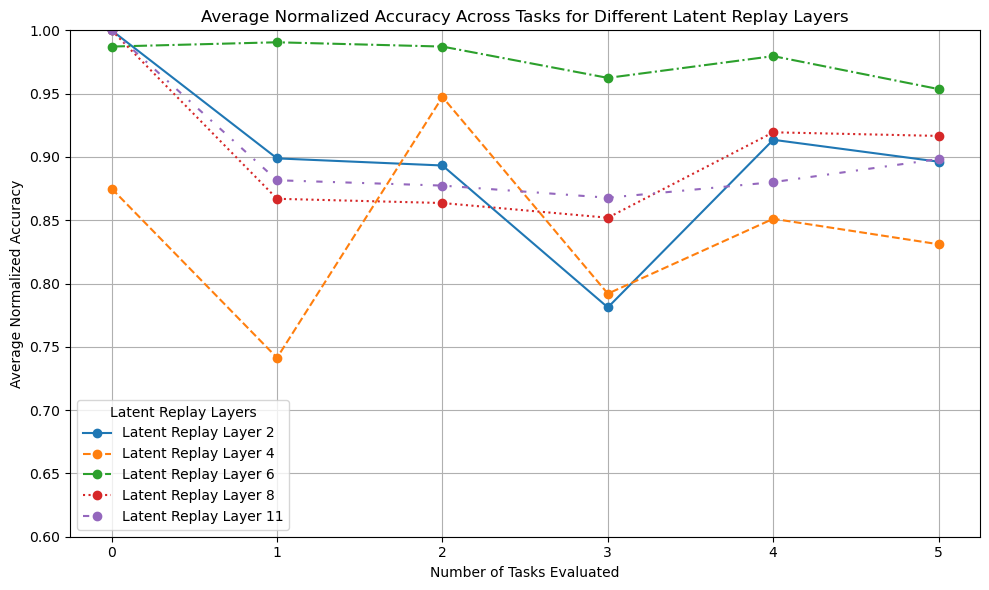

In [16]:
latent_replay_layers = [2, 4, 6, 8, 11]
acc_mtx_dict = {}

for layer in latent_replay_layers:
    saving_path = os.path.join(args.output_dir, f"latent_replay_{layer}_model")
    accuracy_file = os.path.join(saving_path, "accuracy_results.txt")
    
    with open(accuracy_file, "r") as f:
        lines = f.readlines()
        task_lists = lines[0].strip().split(",")
        acc_results_pad = [line.strip().split(",") for line in lines[1:]]
        acc_results_pad = [[float(val) if val != '' else np.nan for val in row] for row in acc_results_pad]
        acc_mtx = pd.DataFrame(acc_results_pad, columns=task_lists)
        acc_mtx_dict[layer] = acc_mtx


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1))]

fig, ax = plt.subplots(figsize=(10, 6))

for i, layer in enumerate(latent_replay_layers):
    acc_mtx = acc_mtx_dict[layer]
    tasks = acc_mtx.columns  
    
    normalized_acc_mtx = acc_mtx.divide(acc_mtx.max())
    
    average_normalized_acc = normalized_acc_mtx.mean(axis=1)
    
    x = range(len(average_normalized_acc))
    ax.plot(x, average_normalized_acc, marker='o', color=colors[i % len(colors)], linestyle=line_styles[i % len(line_styles)], label=f'Latent Replay Layer {layer}')

ax.set_title('Average Normalized Accuracy Across Tasks for Different Latent Replay Layers')
ax.set_xlabel('Number of Tasks Evaluated')
ax.set_ylabel('Average Normalized Accuracy')
ax.set_xticks(x)
ax.set_xticklabels([str(j) for j in range(len(x))])
ax.set_ylim(0.6, 1) 
ax.legend(title="Latent Replay Layers")

plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(args.output_dir, "lr_layertest.png"))
plt.show()
